## activation_visualization

We implemented activation visualization using SAE on LLava-Mistral 7B, enabling us to separately compute the l0 of SAE on text tokens and image tokens.

In [2]:
import os
import pdb
from typing import Any, cast
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
from PIL import Image
from sae_lens import SAE
from torchvision.transforms.functional import to_pil_image
from transformer_lens.HookedLlava import HookedLlava
from transformer_lens import HookedChameleon
from transformers import LlavaNextForConditionalGeneration, LlavaNextProcessor
from transformers import ChameleonForConditionalGeneration, AutoTokenizer, ChameleonProcessor
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)
import seaborn as sns
from sae_lens.activation_visualization import load_llava_model, load_chameleon_model,load_sae,prepare_input,generate_with_saev,map_patches_to_image,overlay_activation_on_image

Model loading

In [ ]:
# please replace these path to your own path
MODEL_NAME = "llava-hf/llava-v1.6-mistral-7b-hf"
model_path = "/data/models/llava-v1.6-mistral-7b-hf"
device = "cuda:0"
sae_device = "cuda:7"
sae_path = "/data/changye/model/llavasae_obliec100k_SAEV"
dataset_path = "/mnt/data/changye/data/obelics3k-tokenized-llava4096"
columns_to_read = ["input_ids", "pixel_values", "attention_mask", "image_sizes"]

save_path = "../activation_visualization"


(
        processor,
        vision_model,
        vision_tower,
        multi_modal_projector,
        hook_language_model,
) = load_llava_model(MODEL_NAME, model_path, device,n_devices=8)

sae = load_sae(sae_path, sae_device)





Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Quantization check time: 0.00s
Configuration loading time: 0.00s
Model configuration processing time: 1.02s
State dict loading time: 0.01s
Tokenizer setup time: 0.07s
Embedding setup time: 63.75s
Move device time: 0.00s
Set up time: 0.00s
Model creation time: 63.83s
State dict processing time: 34.59s


OutOfMemoryError: CUDA out of memory. Tried to allocate 502.00 MiB. GPU 0 has a total capacity of 23.60 GiB of which 324.81 MiB is free. Process 360303 has 21.79 GiB memory in use. Including non-PyTorch memory, this process has 1.47 GiB memory in use. Of the allocated memory 1.21 GiB is allocated by PyTorch, and 16.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

: 

Input loading

In [22]:
example_prompt = "What is shown in the image?"
# example_prompt = " "
image_path = "../image_source/bas_female.jpg"
inputs, image = prepare_input(processor,device, image_path, example_prompt)
print(inputs['input_ids'])
# i, j = 0, 5

# input_ids = inputs['input_ids']

# tmp=input_ids[0, j].clone()
# tensor_without_element = torch.cat([input_ids[0, :j], input_ids[0,(j+1):]])
# input_ids = torch.cat([tensor_without_element[:i],tmp.unsqueeze(0),tensor_without_element[i:]])
# inputs['input_ids']=input_ids.unsqueeze(0)
# print(inputs['input_ids'])

tensor([[    1,   733, 16289, 28793,  1824,   349,  4894,   297,   272,  3469,
         28804, 32000, 28705,   733, 28748, 16289, 28793]], device='cuda:5')


Generate

In [23]:
total_activation_l1_norms_list,patch_features_list,feature_act_list,image_indice=generate_with_saev(
        inputs, hook_language_model, processor, save_path, image, sae, sae_device
    )
feature_act_list=[feature_act[0] for feature_act in feature_act_list]
print(feature_act_list[0].shape)

  0%|          | 0/30 [00:00<?, ?it/s]

[INST] What is shown in the image?  [/INST] This is an action photograph showing a group of young girls playing basketball on a gym floor. The girls are dressed in athletic uniforms with a combination
torch.Size([1192, 65536])


In [91]:
print(image_indice)

tensor([   5,    6,    7,  ..., 1178, 1179, 1180])


Activation Visualization

In [24]:
current_activation_map = map_patches_to_image(total_activation_l1_norms_list[0],max_val=1000)
final_image = overlay_activation_on_image(image, current_activation_map,alpha=128)
final_image.save(os.path.join(save_path, f"bas_male.png"))

In [6]:
text_act_list = []
for feature_act in feature_act_list:
    all_indices = torch.arange(feature_act.shape[0])
    combined_indices = torch.cat((all_indices,image_indice))
    unique,counts=torch.unique(combined_indices,return_counts=True)
    difference = unique[counts == 1]
    # print(all_indices.shape)
    # print(combined_indices.shape)
    # print(difference)
    text_act_list.append(feature_act[difference])

In [ ]:
# text_act_count_list=[(text_act!=0).sum(1) for text_act in text_act_list]
# print(text_act_count_list[0].shape)

torch.Size([16])


Global Activation

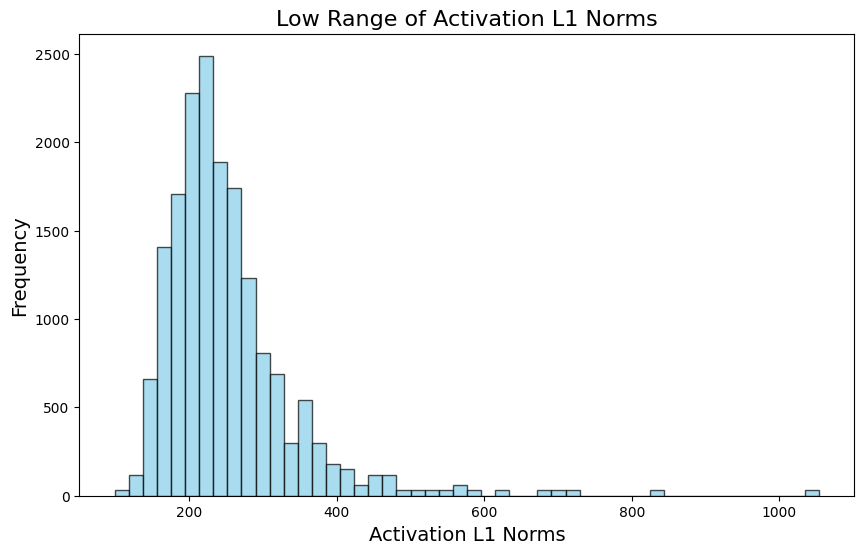

high_values [259735.06     1672.4127 259735.06     1672.4128 259735.06     1672.4131
 259735.08     1672.4128 259735.06     1672.4127 259735.06     1672.4128
 259735.06     1672.4131 259735.08     1672.4128 259735.06     1672.4127
 259735.06     1672.4128 259735.06     1672.4131 259735.08     1672.4128
 259735.06     1672.4127 259735.06     1672.4128 259735.06     1672.4131
 259735.08     1672.4128 259735.06     1672.4127 259735.06     1672.4128
 259735.06     1672.4131 259735.08     1672.4128 259735.06     1672.4127
 259735.06     1672.4128 259735.06     1672.4131 259735.08     1672.4128
 259735.06     1672.4127 259735.06     1672.4128 259735.06     1672.4131
 259735.08     1672.4128 259735.06     1672.4127 259735.06     1672.4128]


In [ ]:
global_activation_l1_norms = torch.cat(total_activation_l1_norms_list)

global_activation_l1_norms_flat = global_activation_l1_norms.flatten()


global_activation_l1_norms_np = global_activation_l1_norms_flat.cpu().numpy()

min_value = global_activation_l1_norms_np.min()
if min_value <= 0:
    shift = abs(min_value) + 1e-6
    global_activation_l1_norms_np_shifted = global_activation_l1_norms_np + shift
else:
    global_activation_l1_norms_np_shifted = global_activation_l1_norms_np

low_values = global_activation_l1_norms_np[global_activation_l1_norms_np < 1500]
high_values = global_activation_l1_norms_np[global_activation_l1_norms_np >= 1500]

plt.figure(figsize=(10, 6))
plt.hist(low_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Low Range of Activation L1 Norms', fontsize=16)
plt.xlabel('Activation L1 Norms', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

print("high_values",high_values)

# plt.figure(figsize=(10, 6))
# plt.hist(high_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
# plt.title('High Range of Activation L1 Norms', fontsize=16)
# plt.xlabel('Activation L1 Norms', fontsize=14)
# plt.ylabel('Frequency', fontsize=14)
# plt.show()

In [10]:
print(high_values.shape)

(60,)


torch.Size([576])


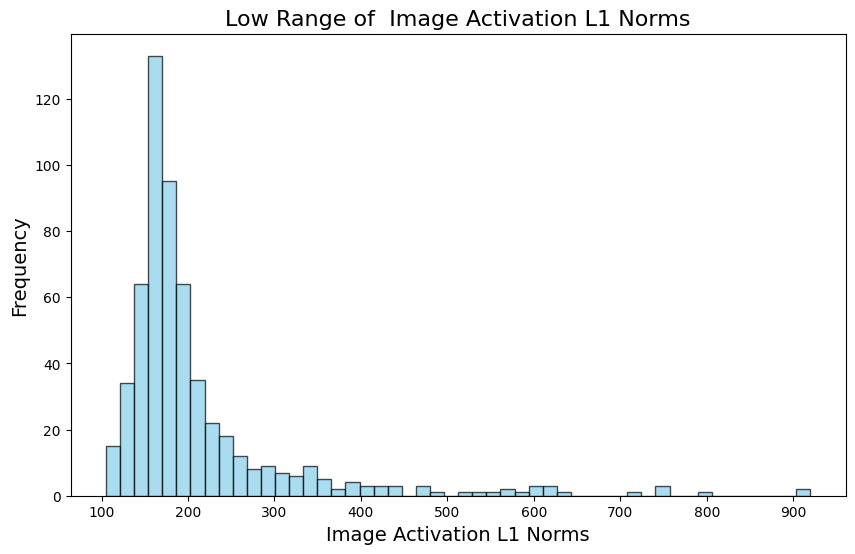

high_values tensor([4811.])


In [15]:
# patch_indices = torch.stack(
#         (valid_indices[:576], valid_indices[576:]), dim=1
#     )
#     patch_features = feature_acts[:, patch_indices]
l0_feature_list = []
for patch_feature in patch_features_list:
    patch_feature=(patch_feature!=0).sum(-1)
    patch_feature=patch_feature.sum(-1)
    l0_feature_list.append(patch_feature)
print(l0_feature_list[0].shape)
image_activation_l0_norms = torch.stack(l0_feature_list).sum(0)/len(l0_feature_list)

low_values = image_activation_l0_norms[image_activation_l0_norms < 1000]
high_values = image_activation_l0_norms[image_activation_l0_norms >= 1000]

plt.figure(figsize=(10, 6))
plt.hist(low_values ,bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Low Range of  Image Activation L1 Norms', fontsize=16)
plt.xlabel('Image Activation L1 Norms', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

print("high_values",high_values)